In [14]:
%load_ext autoreload
%autoreload 2
from dask.diagnostics import ProgressBar
import so_decadal_variability.process as process
import so_decadal_variability.grid as sogrid
import so_decadal_variability.wmt as wmt
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

In [24]:
F = {}
Fmean = {}
# Load observational data
fluxnames=['erai','era5','jra55','merra2']
oceanname='en4'
timeslice = slice('1980','2018')
dg = 0.1
for fluxname in fluxnames:
    ds = process.loaddata(fluxname,oceanname,timeslice)
    ds, xgrid = sogrid.get_xgcm(ds)
    F[fluxname] = wmt.calc_densityflux(ds,xgrid)
    Fmean[fluxname] = F[fluxname].sum('depth').mean('time')

In [34]:
with ProgressBar():
    Fmean['merra2'].load()

[########################################] | 100% Completed | 18.4s


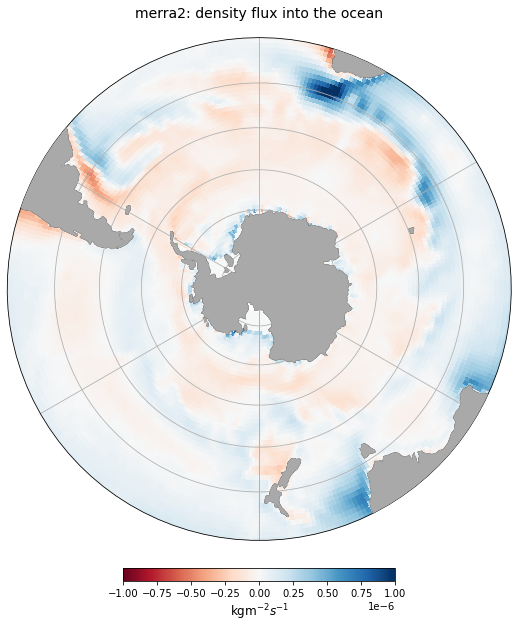

In [35]:
fluxname = 'merra2'
Y = Fmean[fluxname]['lat'].values
X = Fmean[fluxname]['lon'].values

Z,X = add_cyclic_point(Fmean[fluxname]['total'],X)

fig,ax = draw_SOcustom(X,Y,Z,
                        cmap='RdBu',cbar_label='kgm$^{-2}s^{-1}$',
                          title = fluxname+': density flux into the ocean', plot_type='pcolormesh',clims=[-1E-6,1E-6])